In [39]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import h5py
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

import ecg_settings

from tensorflow.keras.models import load_model
from ml4h.models.model_factory import get_custom_objects
from ml4h.tensormap.ukb.survival import mgb_afib_wrt_instance2
from ml4h.tensormap.ukb.demographics import age_2_wide, af_dummy, sex_dummy3

In [2]:
def ecg_as_tensor(ecg_file):
    with h5py.File(ecg_file, 'r') as hd5:
        tensor = np.zeros(ecg_settings.ECG_SHAPE, dtype=np.float32)
        for lead in ecg_settings.ECG_REST_LEADS:
            data = np.array(hd5[f'{ecg_settings.ECG_HD5_PATH}/{lead}/instance_0'])
            tensor[:, ecg_settings.ECG_REST_LEADS[lead]] = data
        tensor -= np.mean(tensor)
        tensor /= np.std(tensor) + 1e-6
    return tensor

In [3]:
ecg_file = "/Users/bellaluciani/Downloads/fake_0.hd5"
ecg_tensor = ecg_as_tensor(ecg_file)
print(type(ecg_tensor), ecg_tensor.shape)

<class 'numpy.ndarray'> (5000, 12)


In [33]:
custom_dict = get_custom_objects([mgb_afib_wrt_instance2, age_2_wide, af_dummy, sex_dummy3])
model = load_model("../models/ecg_5000_survival_curve_af_quadruple_task_mgh_v2021_05_21.h5", custom_objects=custom_dict)
predictions = model.predict(np.expand_dims(ecg_tensor, axis=0))

1/1 [==============================] - 1s 547ms/step


In [34]:
for i, pred in enumerate(predictions):
    print(f"pred {i}: a {type(pred)} of shape {pred.shape}")

pred 0: a <class 'numpy.ndarray'> of shape (1, 50)
pred 1: a <class 'numpy.ndarray'> of shape (1, 2)
pred 2: a <class 'numpy.ndarray'> of shape (1, 1)
pred 3: a <class 'numpy.ndarray'> of shape (1, 2)


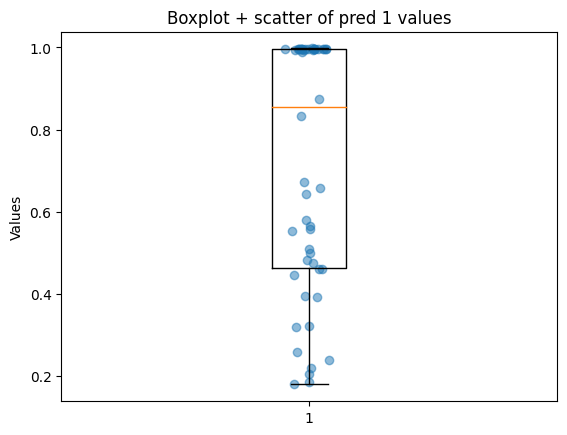

In [40]:
plt.boxplot(predictions[0].flatten())
x_jitter = np.random.normal(1, 0.02, size=len(predictions[0].flatten())) 
plt.scatter(x_jitter, predictions[0].flatten(), alpha=0.5, label="Data Points")
plt.ylabel("Values")
plt.title("Boxplot + scatter of pred 1 values")
plt.show()


In [50]:
box_data = go.Box(
    y=predictions[0].flatten(),
    name='pred_1',
    boxmean='sd',
    marker=dict(color='blue'),
    boxpoints='all',
    pointpos=0
)

fig = go.Figure(data=[box_data])

fig.update_layout(
    title="Box Plot of First Predicted Output with Points Overlayed",
    yaxis_title="Values",
    xaxis_title="",
)
fig.show()

In [38]:
pred_df= pd.DataFrame({"prediction": [
        predictions[1].flatten().tolist(),
        predictions[2].flatten().tolist(),
        predictions[3].flatten().tolist()
    ]
}, index=["pred_2", "pred_3", "pred_4"])

display(pred_df)

,prediction
pred_2,"[0.2934797406196594, 0.7065202593803406]"
pred_3,[-0.05254749953746796]
pred_4,"[0.9834609031677246, 0.01653912477195263]"


In [53]:
fig = go.Figure(data=[go.Table(
                header=dict(values=["Output", "Prediction"], 
                            fill_color='lightblue', 
                            align='left'),
                cells=dict(values=[pred_df.index, 
                                   pred_df['prediction']],
                                   fill_color='white', 
                                   align='left'))
])

fig.update_layout(title="Output of of Predictions 2-4")

fig.show()